# 0. Set Up

In [54]:
# Import general modules/packages here. 
# It is a good practice to run all cells in the Notebook sequentially to avoid unexpected outputs.

import numpy as np

# force Jupyter to update loaded modules as they change 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Before you continue ...
Please download and add the folder from the exercise page to the root directory of this project.      
www.rostlab.org/~bindpredict/datasets_pp1cb/disorder.zip


The folder name should be **data**. The folder contains following files: 


-- baseline_embeddings_disorder.h5     
-- disorder_seq.fasta    
-- README.md      
-- disorder_labels.fasta     
-- MSAs      
 
 
**TO DO**: add a method for automatical download.


Run the next cell to display the structure of the repo: 

In [55]:
!ls

data  methods  README.md  visualization  workflow.ipynb


**methods** 


-- utils    
-- nn
 Contains the actual code for pre-processing and definition of our NN. 


**visualization**     
Contains methods for ploting and the output folder with images. 



This notebook is meant to be a main driver which imports all methods and performs machine learning pipeline in abstract high-level calls. It means: we will implement the actual dataset import, network definition and training here by importing an appropriate function into the notebook. 

# Table of contents 
TO DO 

# 1. Dataset preparation

## Visualize the dataset

Reading Z-scores...done! Found 1102 proteins.
Plotting histogram of all z-scores...done! 125223 usable z-scores in total. 5.05% of all z-scores were unknown and hence removed from the histogram.
Plotting histogram of the protein lengths...done! Median length: 114.0.


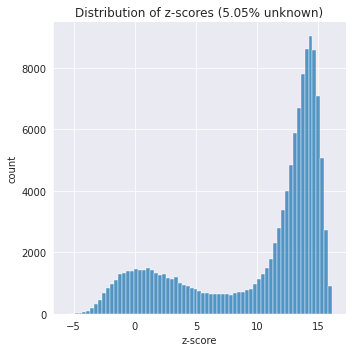

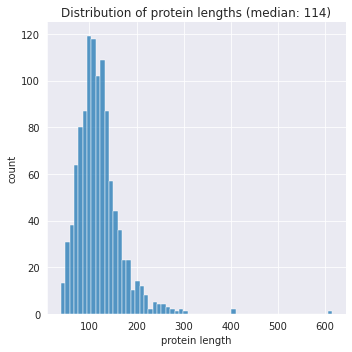

In [56]:
import visualization.visualize_dataset as vis
from methods.utils.read_embeddings import read_z_scores

z_scores = read_z_scores(z_score_file="./data/disorder_labels.fasta")
vis.plot_z_score_histogram(z_scores)
vis.plot_protein_length_histogram(z_scores)

## Embeddings
Here is an example how an embedding works. 
Each aa seq is represented as a numpy array of size (num_of_aa, 1024), where each number is a z-score. 

In [57]:
test_index = np.random.randint(10)
test_x = dataset.x[test_index]
test_y = dataset.y[test_index]
seq_length, embedding_dim = test_x.shape
print(test_x.shape)
print(test_y.shape)
test_y.sum()/len(test_y)

(54, 1024)
(54,)


49.65272222222223

## Load the dataset

In [58]:
import methods.nn.disorder_dataset as dd

dataset = dd.load_dataset()

Reading embeddings...done! Found 1102 proteins.
Reading Z-scores...done! Found 1102 proteins.
Matching protein IDs...done!
Samples per bin [ 94  66 256 686]
Thresholds of bins [-1.89092126  2.24897056  6.38886238 10.5287542  14.66864602]


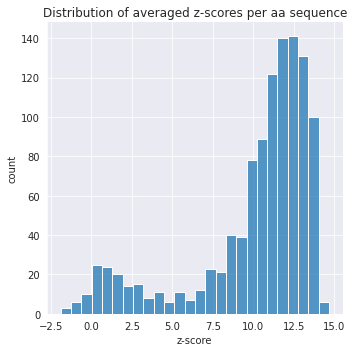

In [59]:
from visualization.visualize_dataset import plot_avg_z_score_histogramm

plot_avg_z_score_histogramm(dataset.avg_y)

## Split the dataset to k-folds

### Sample train/test/val datasets k-times
Sampling from each of the bins ensures stratification or, in other words, that the distribution of the data is equal in every set. 


In [60]:
import torch 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from methods.nn.disorder_dataset import DisorderDataset


def nested_cross_validation(dataset,
                            model=None,
                            mode='print_fold_info',
                            k=10, *kwargs):
    
    # Set fixed random number seed
    SEED = 1
    torch.manual_seed(SEED) 
    
    # Define the K-fold Cross Validator
    skf = StratifiedKFold(n_splits=k, random_state=SEED, shuffle=True)

    # For folds results
    results = {}
    # For debugging loaders 
    loaders = {}

    # Nested K-Fold Cross Validation model evaluation
    # We split the data stratified on artificially constructed bins in df['bins'
    # and extract indices.
    
    # By splitting we only extract indices of samples for each test/train/val sets,
    # thus we only need either X or y (equal length).
    # For stratification, however, we require the artificially assigned bins whic are also defined in the 
    # dataset class
    
    data = dataset.y
    stratify_on = dataset.bins
    
    for fold, (train_val_ids, test_ids) in enumerate(skf.split(data,stratify_on)):
        
        print(f"Fold {fold}")
        
        train_ids, val_ids = train_test_split(train_val_ids, 
                                  test_size=0.25,  # 0.25 x 0.8 = 0.2
                                  stratify=stratify_on[train_val_ids], 
                                  random_state=SEED)
    

        # Define data loaders for training and testing data in this fold
        valloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=10, sampler=val_ids)

        trainloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=10, sampler=train_ids)

        testloader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=10, sampler=test_ids)
        
        if mode == 'print_fold_info':
            
            loaders[fold] = [trainloader, valloader, testloader]
            
            print('train -  {}, avg_len - {:.2f}  |  val -  {}, avg_len - {:.2f}'.format(
                np.bincount(stratify_on[train_ids]),
                np.sum(dataset.aa_len[train_ids])/len(train_ids),
                np.bincount(stratify_on[val_ids]),
                np.sum(dataset.aa_len[val_ids])/len(val_ids)))

            print('test -  {}, avg_len - {:.2f}'.format(
                np.bincount(stratify_on[test_ids]),
                np.sum(dataset.aa_len[test_ids])/len(test_ids)))
                  
            print()
            
        elif mode == 'evaluate':
            pass
        else:
            print("Mode is not specified!")
            break
        
    if mode == 'evaluate':
        return results
    else:
        return loaders

In [62]:
nested_cross_validation(dataset)

Fold 0
train -  [  0  64  44 172 463], avg_len - 120.64  |  val -  [  0  21  15  58 154], avg_len - 115.95
test -  [ 0  9  7 26 69], avg_len - 121.62

Fold 1
train -  [  0  64  44 172 463], avg_len - 118.91  |  val -  [  0  21  15  58 154], avg_len - 122.10
test -  [ 0  9  7 26 69], avg_len - 119.47

Fold 2
train -  [  0  63  45 173 463], avg_len - 120.90  |  val -  [  0  21  15  58 154], avg_len - 116.34
test -  [ 0 10  6 25 69], avg_len - 118.97

Fold 3
train -  [  0  63  45 173 463], avg_len - 119.58  |  val -  [  0  21  15  58 154], avg_len - 117.34
test -  [ 0 10  6 25 69], avg_len - 125.65

Fold 4
train -  [  0  63  45 173 463], avg_len - 120.22  |  val -  [  0  21  15  58 154], avg_len - 118.38
test -  [ 0 10  6 25 69], avg_len - 118.98

Fold 5
train -  [  0  63  45 173 463], avg_len - 120.82  |  val -  [  0  21  15  58 154], avg_len - 116.12
test -  [ 0 10  6 25 69], avg_len - 120.01

Fold 6
train -  [  0  64  44 173 463], avg_len - 118.32  |  val -  [  0  21  15  57 155], avg_

{0: [<torch.utils.data.dataloader.DataLoader at 0x7f0302b35cf8>,
 1: [<torch.utils.data.dataloader.DataLoader at 0x7f0302b2e748>,
 2: [<torch.utils.data.dataloader.DataLoader at 0x7f0302b2eb70>,
 3: [<torch.utils.data.dataloader.DataLoader at 0x7f0302c202e8>,
 4: [<torch.utils.data.dataloader.DataLoader at 0x7f0302c20710>,
 5: [<torch.utils.data.dataloader.DataLoader at 0x7f0302c209b0>,
 6: [<torch.utils.data.dataloader.DataLoader at 0x7f0302c13cc0>,
 7: [<torch.utils.data.dataloader.DataLoader at 0x7f0302c13278>,
 8: [<torch.utils.data.dataloader.DataLoader at 0x7f0302c06e10>,
 9: [<torch.utils.data.dataloader.DataLoader at 0x7f0302c06c88>,
  <torch.utils.data.dataloader.DataLoader at 0x7f0302c069b0>]}

In [61]:
# TO DO :

# We need to define collate_fn function to be able to load samples x into the DataLoader of PyTorch
# The problem is that each embedding has different length, as well as each output y. 
# PyTorch however tries to align all in/outputs to one matrix and encounters a problem that size is not constant.
# Here is some information about collate_fn 

# https://discuss.pytorch.org/t/dataloader-gives-stack-expects-each-tensor-to-be-equal-size-due-to-different-image-has-different-objects-number/91941

# What we could think about is to pad the data before loading it into the DataLoader.
# 

from torch.utils.data import DataLoader

test_loader = DataLoader(dataset, batch_size=10)
for batch in test_loader:
    print(len(batch))

RuntimeError: stack expects each tensor to be equal size, but got [190, 1024] at entry 0 and [54, 1024] at entry 1

# 2. Create a model
TO DO

# 3. Train a model
TO DO

# 4. Visualize results